## 1. 支持向量机 

支持向量机(Support Vector Machine, SVM): 有监督机器学习模型，有两个特点：1. 能同时用于回归和分类任务；2. 能同时拟合线性和非线性关系。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## 2. SVM工作原理

为了理解SVM的工作原理，让我们考虑一个简单的分类问题。假设两个数值特征$X_1, X_2$，目标变量有两个类别，将特征映射到笛卡尔坐标系中，如下图所示。

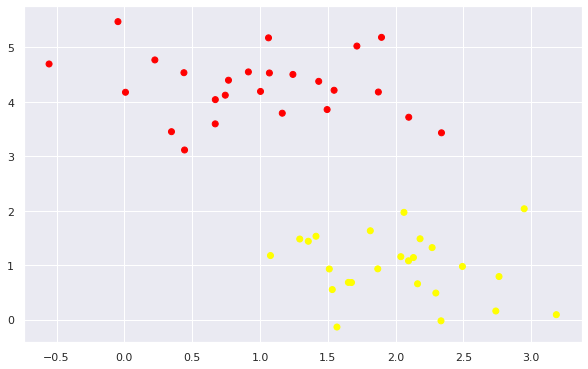

In [3]:
from sklearn.datasets.samples_generator import make_blobs

# 使用make_blobs生成样本数据，将数据集明确归类为两个类别
X, y = make_blobs(
    n_samples=50,  # 观测值数量
    n_features=2,  # 特征数量
    centers=2,  # 目标变量的类别数
    random_state=0,
    cluster_std=0.6  # 集群中数据点的标准差
)

# 散点图，按照目标变量y区分颜色
fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:,0], X[:,1], c=y, cmap="autumn")

我们的目标是找到最优的分割超平面(在二维平面中就是一条直线)，将两个类完全区分。

如下图所示，可以绘制任意多的分割超平面，但哪个才是最优的模型？解决思路是围绕原始的分割超平面，建立两个平行的边界超平面，边界超平面与部分样本点相切，**最大化两个边界间的距离**。这就是SVM的工作原理，落在边界上的样本点被称为'支持向量(support vector)'。

(-0.1, 3.5)

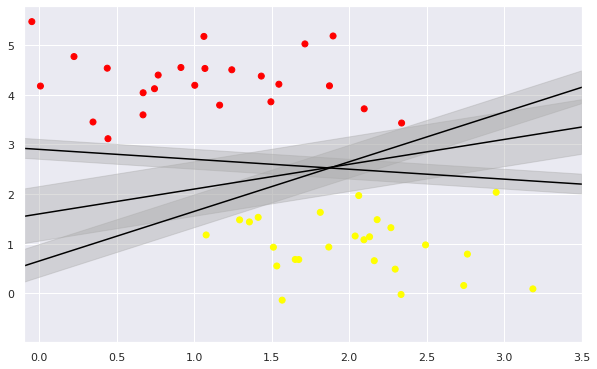

In [4]:
xfit = np.linspace(-1, 3.5)

fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:,0], X[:,1], c=y, cmap="autumn")

coffs = [
    [0.65, 1, 0.33],  # 截距系数，斜率系数，带宽
    [1.6, 0.5, 0.55],
    [2.9, -0.2, 0.2]
]
for a,b,c in coffs:
    yfit = a + b * xfit
    ax.plot(xfit, a + b * xfit, color="black")
    ax.fill_between(xfit, yfit - c, yfit + c, edgecolor="none",
                    color='#AAAAAA', alpha=0.4)

ax.set_xlim(-0.1, 3.5)

## 3. sklearn实现SVM

### 3.1 线性分类

上面的例子可以找到一个分割超平面，完全划分两个类，现实的情况往往并非如此。让我们生成一个贴近现实的数据集，包含两个数值特征，目标变量有两个类别，但部分样本点有重叠。

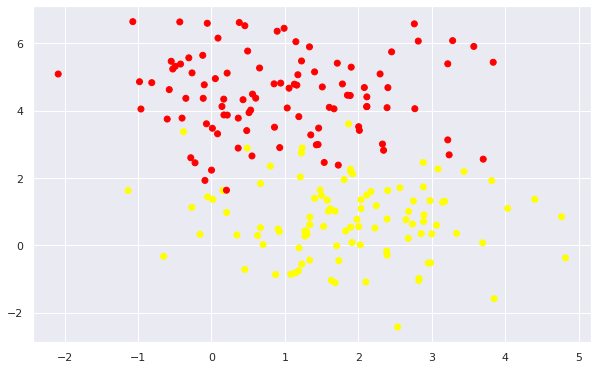

In [5]:
X, y = make_blobs(
    n_samples=200,  # 观测值数量
    n_features=2,  # 特征数量
    centers=2,  # 目标变量的类别数
    random_state=0,
    cluster_std=1.2  # 集群中数据点的标准差
)

# 散点图，按照目标变量y区分颜色
fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:,0], X[:,1], c=y, cmap="autumn")

sklearn提供SVC类，这是实现支持向量机分类模型的通用接口。

In [6]:
from sklearn.svm import SVC

model = SVC(C=1.0, kernel="linear")
model.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

查看支持向量，即落在边界超平面内部的点。

In [7]:
model.support_vectors_

array([[-8.90728186e-02,  1.92683157e+00],
       [ 1.42798072e+00,  2.98450638e+00],
       [ 1.53506501e+00,  2.46029490e+00],
       [ 9.29130697e-01,  2.90207513e+00],
       [ 5.51477385e-01,  2.65384578e+00],
       [ 4.94540093e-04,  2.23224820e+00],
       [-2.23988338e-01,  2.45006201e+00],
       [ 2.34355090e+00,  2.82199634e+00],
       [ 1.45147813e+00,  2.99211352e+00],
       [ 3.21733967e+00,  3.13105387e+00],
       [ 1.72654782e+00,  2.38131814e+00],
       [ 3.23605092e+00,  2.68647645e+00],
       [ 2.03927995e-01,  1.63570354e+00],
       [-2.81993480e-01,  2.59976580e+00],
       [ 2.32823319e+00,  3.00786952e+00],
       [ 3.69997563e+00,  2.55854852e+00],
       [-1.13573916e+00,  1.62524709e+00],
       [ 1.22480770e+00,  2.74131613e+00],
       [-3.81553840e-01,  3.37505509e+00],
       [ 8.00963482e-01,  2.35103801e+00],
       [ 1.89482565e+00,  2.19095623e+00],
       [ 1.86606710e+00,  3.60573186e+00],
       [ 4.87435299e-01,  2.88742048e+00],
       [ 1.

SVC包含两个重要参数：kernel和C。在线性分类问题中，只需要将kernel设置为'linear'即可。参数C控制分割超平面边界的宽度，C越小宽度越大，边界内部可以包含更多的样本点，相反C越大边界越窄。

我们写一个自定义函数绘制线性支持向量机的超平面边界，对比一下调整参数C的分类结果。

**实际建模中应该使用网格搜索找到最优参数。**

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """绘制线性SVM的分割超平面边界"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=200, linewidths=1, facecolors='none',
                   edgecolors="black");
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

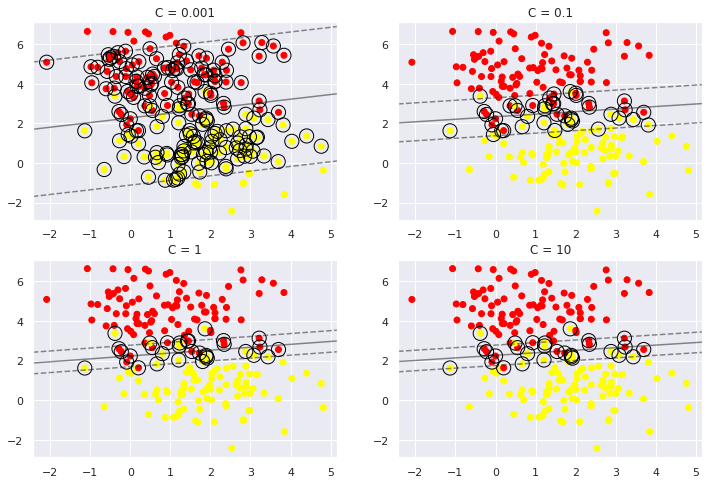

In [9]:
# 参数C决定了边界的灵活度，C越小，边界越宽，C越大，边界越窄
c_rng = [0.001, 0.1, 1, 10]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = ax.flatten()

for i,c in enumerate(c_rng):
    axes[i].scatter(X[:,0], X[:,1], c=y, cmap="autumn")
    model = SVC(C=c, kernel="linear")
    model.fit(X, y)
    plot_svc_decision_function(model, ax=axes[i])
    axes[i].set_title(f"C = {c}")

### 3.2 非线性分类

当处理非线性问题时，需要把原始变量投影到更高维度的空间，使原始变量实现线性分离。

SVM处理非线性问题时也使用了同样的原理，但将每个特征向量进行非线性转化会大幅增加计算复杂度，所以SVM引入了核机制的技术。

sklearn实现SVM时提供3种核函数，专门用于解决非线性问题：

1. 径向内核(Radial Basis Function)，默认内核
2. 多项式核(Polynomial kernel)
3. Sigmoid(Sigmoid kernel)

让我们先生成一个非线性的数据集。

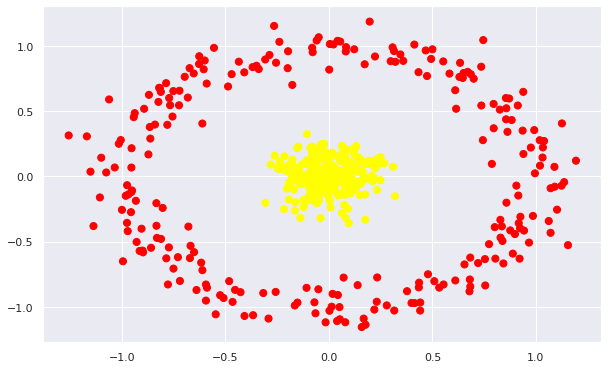

In [10]:
from sklearn.datasets.samples_generator import make_circles

X,y = make_circles(n_samples=500, factor=0.1, noise=0.1, random_state=0)

fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap="autumn")

接下来我们用SVM解决非线性问题，通过网格搜索寻找最优的核函数和参数C。

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC()
param_grid = {
    "C": [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=10,
    n_jobs=5
)

grid.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5,
                               3.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

获取最优超参数，当参数C=0.1，使用径向基内核时模型表现最好。

In [12]:
grid.best_params_

{'C': 0.1, 'kernel': 'rbf'}

获取最优评分，准确率高达100%。

In [13]:
grid.best_score_

1.0

获取最优模型，可视化分割超平面边界。

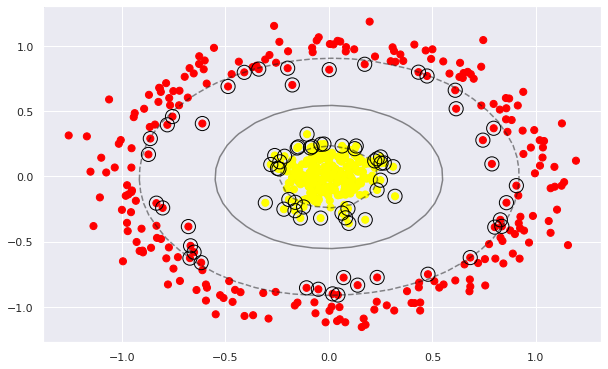

In [14]:
opt_model = grid.best_estimator_

fig, ax = plt.subplots(figsize=(10, 6.18))
ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(opt_model, ax=ax)

### 3.3 回归问题

sklearn提供3种通用接口实现回归模型:

1. SVR
2. nuSVR
3. LinearSVR

SVR和nuSVR是两种不同的算法实现，目的和超参数都相似，SVR和LinearSVR的区别在于：SVR能同时解决线性和非线性问题但只能用于小型数据集，LinearSVR只能解决线性问题，但适用于大型数据集。

超参数：

1. C: 惩罚参数，C越小间隔越大(分割超平面的边界越宽)，忽略更多的噪音，使模型的泛化性更好。
2. kernel: 核函数，可以设置为'linear(线性)','poly(多项式)','rbf(径向基函数)','sigmoid'，最常用的是'rbf'.
3. degree: 仅仅适用于多项式核函数(kernel='poly')，决定了多项式的阶数，会被其它核函数忽略。
4. nu: 用于回归模型nuSVR和分类模型nuSVC，该参数近似地表示训练样本被错误分类的可能性，因为它表示相对于训练集的一个比例，所以取值范围在$[0, 1]$，表现和C类似，nu越接近1间隔越大，nu越接近0间隔越小。
5. epsion: 定义1个epsilon大小的范围，该参数描述SVR能接受的错误值是多少。

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

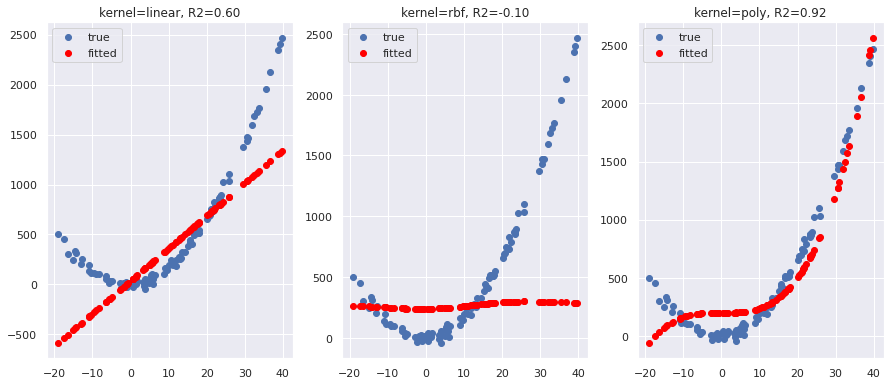

In [42]:
# 生成数据集
np.random.seed(123)
n_samples = 100
X = np.random.uniform(-20, 40, n_samples)
e = np.random.normal(5, 30, n_samples)
y = 1.5 * np.power(X, 2) + 2.5 * X - 5 + e

# SVM回归，分别用线性核，RBF核，多项式核，其它超参数使用默认值
# 多项式核函数使用阶数2(degree=2)
# 用可决系数评估回归模型的拟合优度
kernels = ["linear", "rbf", "poly"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6.18))
for i,axi in enumerate(ax.flatten()):
    model = SVR(kernel=kernels[i], degree=3, C=1.0, epsilon=0.1)
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    axi.scatter(X, y, label="true")
    axi.scatter(X, y_pred, color="red", label="fitted")
    axi.set_title(f"kernel={kernels[i]}, R2={r2:.2f}")
    axi.legend()

## 4. 案例分析：人脸识别

In [2]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)

In [3]:
faces.data.shape

(1348, 2914)

In [4]:
faces.images.shape

(1348, 62, 47)

这里每张图片包含$62*47$约3000个像素。

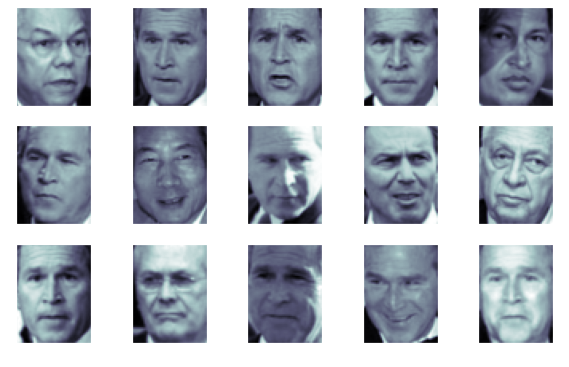

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6.18))
for i,axi in enumerate(ax.flatten()):
    axi.imshow(faces.images[i], cmap="bone")
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(faces.target_names[faces.target[i]], color="white")

数据集包含2914个特征，考虑用PCA降维。

In [6]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [7]:
pca = PCA(n_components=150, whiten=True, random_state=123)
svc = SVC(kernel="rbf", class_weight="balanced")
model = make_pipeline(pca, svc)

首先将数据拆分为训练集和检验集。

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,
                                                    test_size=0.2,
                                                    random_state=123)

为了获得最优模型，使用网格搜索寻找最优参数。

In [9]:
from sklearn.model_selection import GridSearchCV

# model.get_params()  ## 获取模型参数和取值
param_grid = {
    "svc__C": [1, 5, 10, 50],
    "svc__gamma": [0.0001, 0.0005, 0.001, 0.005]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'svc__C': 1, 'svc__gamma': 0.005}


获取最优模型，在检验集上测试预测性能。

In [10]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

预测结果的可视化，观察检验集的前25个结果即可。x轴标签是分类结果，错误的结果用红色字体表示。

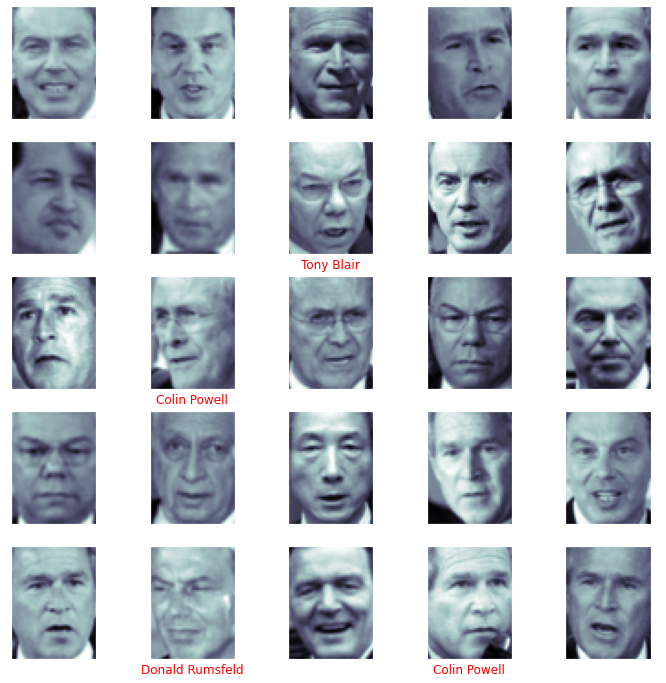

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
for i,axi in enumerate(ax.flatten()):
    axi.imshow(X_test[i].reshape(62, 47), cmap="bone")
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(faces.target_names[y_pred[i]],
                   color="white" if y_pred[i] == y_test[i] else "red")

评估分类模型的性能。

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.71      0.83        21
     Colin Powell       0.73      0.86      0.79        56
  Donald Rumsfeld       0.75      0.71      0.73        21
    George W Bush       0.85      0.89      0.87       101
Gerhard Schroeder       0.95      0.75      0.84        24
      Hugo Chavez       1.00      0.90      0.95        10
Junichiro Koizumi       1.00      1.00      1.00         8
       Tony Blair       0.78      0.72      0.75        29

         accuracy                           0.83       270
        macro avg       0.88      0.82      0.84       270
     weighted avg       0.84      0.83      0.83       270



In [13]:
from sklearn.metrics import confusion_matrix

In [28]:
# sklearn默认将预测值放在x轴(列)，真实值放在y轴(行)
cm = confusion_matrix(y_test, y_pred)
cm

array([[15,  4,  2,  0,  0,  0,  0,  0],
       [ 0, 48,  1,  6,  0,  0,  0,  1],
       [ 0,  2, 15,  4,  0,  0,  0,  0],
       [ 0, 10,  0, 90,  0,  0,  0,  1],
       [ 0,  0,  1,  1, 18,  0,  0,  4],
       [ 0,  0,  0,  1,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  2,  1,  4,  1,  0,  0, 21]])

Text(177.52759999999998, 0.5, 'Actual')

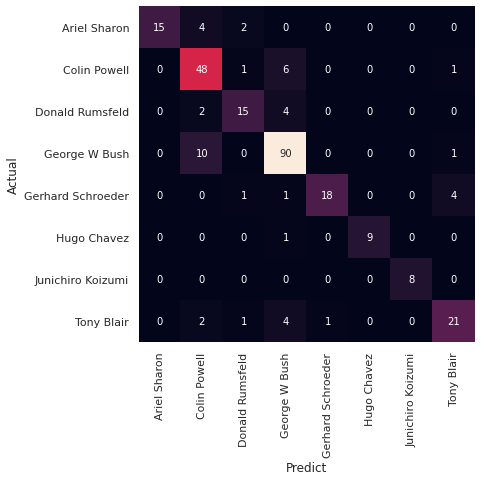

In [29]:
# 只有调用plt的方法才能调整seaborn图像的大小
plt.figure(figsize=(10, 6.18))
sns.heatmap(cm, square=True, annot=True, fmt="d", cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel("Predict")
plt.ylabel("Actual")